# Titanic data analysis

In this workbook, I will share the step-by-step progress of a simple data analysis / machine learning project. In it, I predict the survivors of the Titanic disaster. This is a quick and dirty project, as I hope to move on to something more interesting soon. The data set can be found [here](https://www.kaggle.com/c/titanic/data). 

Each row in the dataset corresponds to a passenger. There are 11 features and 1 target value ("Survived"). there are 892 values in the training set, and over 400 in the test set. Let's get a quick look at the data.

In [10]:
import pandas as pd

inputTrain = '../RawData/train.csv'
train = pd.read_csv(inputTrain, header=0)
train.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Some thoughts on each feature, as it applies to cleaning the data up:
* PassengerId: Is this just an index, or does it have any predictive value? Keep it for now.
* Survived: A binary variable, the target variable.
* Pclass: There are three classes of passenger. Should these be treated as quantities or as categories? I'll keep the classes as quantities. Even if the descent in class does not translate linearly into survival rate, I can adjust for that problem later in the data analysis pipeline.
* Name: Name itself doesn't have any predictive value, but a bunch of binary features can be extracted from a person's name. More on this in the next section.
* Sex: Make this into a binary dummy variable.
* Age: Some ages are missing. How should I interpolate the missing values? And maybe the very fact that an age is unknown is evidence that the passenger did not survive.
* SibSp: The number of same-generation immediate relatives (siblings + spouse) on board. No transformation needed.
* Parch: The number of different-generation immediate relatives (parents + children) on board No transformation needed.
* Ticket: The number might mean something, but with the inconsistent format I'll just delete it
* Fare: No processing needed, except to interpolate missing values by the mean value of "Fare".
* Cabin: The cabin field is missing from over 75% of the passengers. Maybe it'll be helpful to have a feature indicating the unknown status of the cabin. And the letter in "Cabin" indicates a deck on the ship. Maybe "Deck" should be extracted and converted to a categorical dummy variable.
* Embarked: The ship's passengers boarded at one of 3 sites. Make 3 categorical dummy variables.

# Data Munging + Feature Creation

I carried out all of the data munging detailed in the previous section, and created the following features from the "Name" column
* "isMaster": Indicates whether the passenger is a young boy, evident by the presence of ", Master. " in his name. The mean of "Age" where "isMaster" is true is used to interpolate missing ages where the persons's title is "Master".
* "isMiss": Indicates whether the passenger is an unmarried girl or woman, evident by the presence of ", Miss. " in her name. The mean of "Age" where "isMiss" is true is used to interpolate missing ages where the persons's title is "Miss".
* "isMrs": Indicates whether the passenger is a married woman, evident by the presence of ", Mrs. " in her name. The mean of "Age" where "isMrs" is true is used to interpolate missing ages where the persons's title is "Mrs".
* "isMr": Indicates whether the passenger is a grown man, evident by the presence of ", Mr. " in his name. The mean of "Age" where "isMr" is true is used to interpolate missing ages where the persons's title is "Mr".
* "hasNickname": Indicates whether the passenger had a recorded nickname, evident by the presence of quotes in his or her name. My hypothesis is that someone with a recorded nickname is more likely to have survived.
* "hasTitle": Indicates whether the passenger has a formal title in their name, like "Captain", "Dr.", "Baroness", or whatever. My hypothesis is that someone with a formal title is more likely to have survived.

In [12]:
import pandas as pd

inputTrain = '../RawData/train.csv'
inputTest = '../RawData/test.csv'
outputTrain = '../ProcessedData/train.csv'
outputTest = '../ProcessedData/test.csv'

train = pd.read_csv(inputTrain, header=0)
test = pd.read_csv(inputTest, header=0)

avgAgeMaster = train.loc[train['Name'].str.contains(', Master. '), 'Age'].mean()
avgAgeMr = train.loc[train['Name'].str.contains(', Mr. '), 'Age'].mean()
avgAgeMrs = train.loc[train['Name'].str.contains(', Mrs. '), 'Age'].mean()
avgAgeMiss = train.loc[train['Name'].str.contains(', Miss. '), 'Age'].mean()
meanFare = train['Fare'].mean()


def processData(frame, outputURL):
    frame['ageUnknown'] = frame['Age'].isnull()
    frame['cabinUnknown'] = frame['Cabin'].isnull()
    
    frame['isMaster'] = frame['Name'].str.contains(', Master. ')
    frame.loc[(frame['isMaster'] == True) & (frame['Age'].isnull()), 'Age'] = avgAgeMaster
    
    frame['isMr'] = frame['Name'].str.contains(', Mr. ')
    frame.loc[(frame['isMr'] == True) & (frame['Age'].isnull()), 'Age'] = avgAgeMr
    frame.loc[(frame['Name'].str.contains(', Dr. ')) & (frame['Sex'] == 'male'), 'Age'] = avgAgeMr
    
    frame['isMrs'] = (frame['Name'].str.contains(', Mrs. ') | (frame['Name'].str.contains(', Dr. ')) & (frame['Sex'] == 'female'))
    frame.loc[((frame['isMrs'] == True) | (frame['Name'].str.contains(', Ms. '))) & (frame['Age'].isnull()), 'Age'] = avgAgeMrs
    #frame.loc[(frame['Name'].str.contains(', Dr. ')) & (frame['Sex'] == 'female'), 'Age'] = avgAgeMrs
    
    frame['isMiss'] = frame['Name'].str.contains(', Miss.')
    frame.loc[(frame['isMiss'] == True) & (frame['Age'].isnull()), 'Age'] = avgAgeMiss
    
    frame['hasNickname'] = frame['Name'].str.contains('\"')
    
    frame['hasTitle'] = ((frame['Name'].str.contains(', Dr. ') & (frame['Name'].str.contains(', Ms. ') == False)) | ((frame['isMr'] == False) & (frame['isMrs'] == False) & (frame['isMaster'] == False) & (frame['isMiss'] == False)))

    frame['A_Deck'] = False
    frame['B_Deck'] = False
    frame['C_Deck'] = False
    frame['D_Deck'] = False
    frame['E_Deck'] = False
    frame['F_Deck'] = False
    frame['G_Deck'] = False

    frame.loc[frame['cabinUnknown'] == False, 'A_Deck'] = frame['Cabin'].str.contains('A')
    frame.loc[frame['cabinUnknown'] == False, 'B_Deck'] = frame['Cabin'].str.contains('B')
    frame.loc[frame['cabinUnknown'] == False, 'C_Deck'] = frame['Cabin'].str.contains('C')
    frame.loc[frame['cabinUnknown'] == False, 'D_Deck'] = frame['Cabin'].str.contains('D')
    frame.loc[frame['cabinUnknown'] == False, 'E_Deck'] = frame['Cabin'].str.contains('E')
    frame.loc[frame['cabinUnknown'] == False, 'F_Deck'] = frame['Cabin'].str.contains('F')
    frame.loc[frame['cabinUnknown'] == False, 'G_Deck'] = frame['Cabin'].str.contains('G')
    
    frame = pd.get_dummies(frame, columns=['Embarked'])
    frame['isMale'] = (frame['Sex'] == 'male')
    del frame['Sex']
    
    frame.loc[frame['Fare'].isnull(), 'Fare'] = float(meanFare)
    
    del frame['Name']
    del frame['Cabin']
    del frame['Ticket']
            
    frame.to_csv(outputURL, index=False)
    print("Done!")
    print(frame.info())

processData(train, outputTrain)
processData(test, outputTest)

Done!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 26 columns):
PassengerId     891 non-null int64
Survived        891 non-null int64
Pclass          891 non-null int64
Age             891 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Fare            891 non-null float64
ageUnknown      891 non-null bool
cabinUnknown    891 non-null bool
isMaster        891 non-null bool
isMr            891 non-null bool
isMrs           891 non-null bool
isMiss          891 non-null bool
hasNickname     891 non-null bool
hasTitle        891 non-null bool
A_Deck          891 non-null bool
B_Deck          891 non-null bool
C_Deck          891 non-null bool
D_Deck          891 non-null bool
E_Deck          891 non-null bool
F_Deck          891 non-null bool
G_Deck          891 non-null bool
Embarked_C      891 non-null float64
Embarked_Q      891 non-null float64
Embarked_S      891 non-null float64
isMale          891

# Exploratory data analysis

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

testPath = '../ProcessedData/test.csv'
trainPath = '../ProcessedData/train.csv'
survivedPath = '../RawData/survived_test.csv'

train = pd.read_csv(trainPath, header=0, index_col=0)
X_test = pd.read_csv(testPath, header=0, index_col=0)
y_test = pd.read_csv(survivedPath, header=0, index_col=0)

train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 25 columns):
Survived        891 non-null int64
Pclass          891 non-null int64
Age             891 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Fare            891 non-null float64
ageUnknown      891 non-null bool
cabinUnknown    891 non-null bool
isMaster        891 non-null bool
isMr            891 non-null bool
isMrs           891 non-null bool
isMiss          891 non-null bool
hasNickname     891 non-null bool
hasTitle        891 non-null bool
A_Deck          891 non-null bool
B_Deck          891 non-null bool
C_Deck          891 non-null bool
D_Deck          891 non-null bool
E_Deck          891 non-null bool
F_Deck          891 non-null bool
G_Deck          891 non-null bool
Embarked_C      891 non-null float64
Embarked_Q      891 non-null float64
Embarked_S      891 non-null float64
isMale          891 non-null bool
dtypes: bool(16), float64(

The data munging worked as planned.

In [14]:
train.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,ageUnknown,cabinUnknown,isMaster,isMr,...,B_Deck,C_Deck,D_Deck,E_Deck,F_Deck,G_Deck,Embarked_C,Embarked_Q,Embarked_S,isMale
Survived,1.000000,-0.338481,-0.089135,-0.035322,0.081629,0.257307,-0.092197,-0.316912,0.085221,-0.549199,...,0.175095,0.114652,1.507156e-01,0.150716,0.057935,-0.017955,0.168240,0.003650,-0.155660,-0.543351
Pclass,-0.338481,1.000000,-0.339559,0.083081,0.018443,-0.549500,0.172933,0.725541,0.082081,0.142698,...,-0.369572,-0.417048,-2.786903e-01,-0.221793,0.011063,0.073625,-0.243292,0.221009,0.081720,0.131900
Age,-0.089135,-0.339559,1.000000,-0.271294,-0.195619,0.087487,0.008541,-0.236610,-0.412267,0.237643,...,0.093427,0.117050,1.341540e-01,0.109270,-0.079650,-0.060506,0.041582,-0.050171,-0.012549,0.114682
SibSp,-0.035322,0.083081,-0.271294,1.000000,0.414838,0.159651,0.018958,0.040460,0.349559,-0.250489,...,-0.034538,0.029251,-1.757469e-02,-0.033751,0.001706,-0.019159,-0.059528,-0.026354,0.070941,-0.114631
Parch,0.081629,0.018443,-0.195619,0.414838,1.000000,0.216225,-0.124104,-0.036987,0.267344,-0.333905,...,0.056498,0.030736,-1.912545e-02,-0.011748,0.023694,0.036749,-0.011069,-0.081228,0.063036,-0.245489
Fare,0.257307,-0.549500,0.087487,0.159651,0.216225,1.000000,-0.100707,-0.482075,0.010908,-0.183766,...,0.386297,0.364318,9.887783e-02,0.051749,-0.033093,-0.037921,0.269335,-0.117216,-0.166603,-0.182333
ageUnknown,-0.092197,0.172933,0.008541,0.018958,-0.124104,-0.100707,1.000000,0.144111,-0.053607,0.092886,...,-0.092326,-0.042088,-6.785513e-02,-0.052960,-0.013665,-0.044306,0.033270,0.337413,-0.238377,0.055215
cabinUnknown,-0.316912,0.725541,-0.236610,0.040460,-0.036987,-0.482075,0.144111,1.000000,0.027841,0.137319,...,-0.433053,-0.488683,-3.598957e-01,-0.359896,-0.223299,-0.163300,-0.208528,0.129572,0.110087,0.140391
isMaster,0.085221,0.082081,-0.412267,0.349559,0.267344,0.010908,-0.053607,0.027841,1.000000,-0.254903,...,-0.026914,-0.035937,-4.251856e-02,-0.013819,0.109227,-0.019292,-0.035225,0.010478,0.025291,0.159934
isMr,-0.549199,0.142698,0.237643,-0.250489,-0.333905,-0.183766,0.092886,0.137319,-0.254903,1.000000,...,-0.114673,-0.047873,-4.995170e-02,-0.037910,-0.048235,-0.027349,-0.072567,-0.078338,0.118482,0.867334


Just eyeballing it, it appears that the correlations with "Survival" yield the following insights.
* Lower class = much lower chance of survival

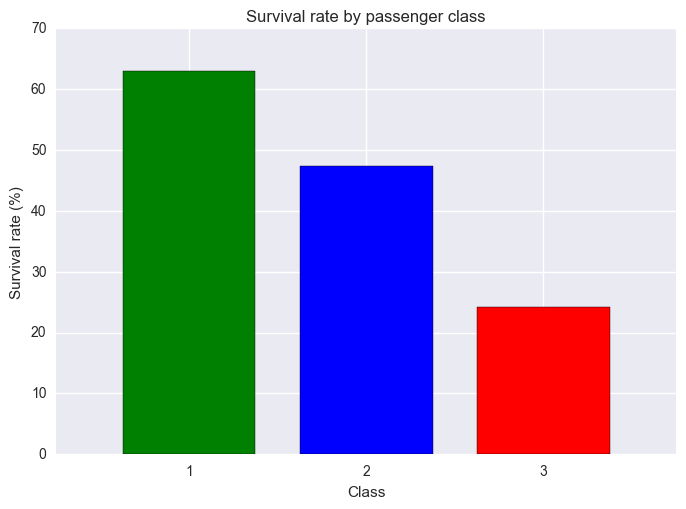

In [15]:
trainLen = train.shape[0]
pclass = [0.75, 1.75, 2.75]
ticks=[1, 2, 3]
colors = ['Green', 'Blue', 'Red']
survival_rate = [train.loc[train['Pclass'] == 1, 'Survived'].mean() * 100, train.loc[train['Pclass'] == 2, 'Survived'].mean() * 100, train.loc[train['Pclass'] == 3, 'Survived'].mean() * 100]
plt.bar(left=pclass, height=survival_rate, color=colors, width=0.75, tick_label=ticks, align='center')
plt.title("Survival rate by passenger class")
plt.xlabel("Class")
plt.ylabel("Survival rate (%)")
plt.show()

* Higher fare = higher chance of survival

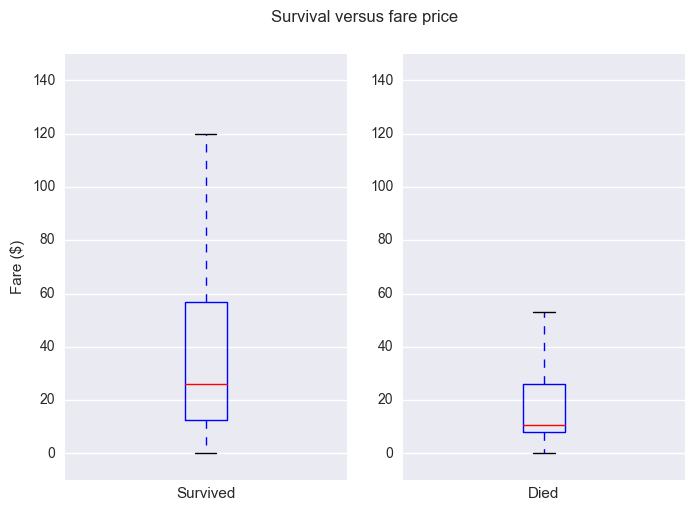

In [16]:
plt.subplot(1, 2, 1)
plt.suptitle("Survival versus fare price")
plt.boxplot(x=list(train.loc[train['Survived'] == True, 'Fare']))
plt.ylim(-10, 150)
plt.xlabel("Survived")
plt.ylabel("Fare ($)")
plt.xticks([])
plt.subplot(1, 2, 2)
plt.boxplot(x=list(train.loc[train['Survived'] == False, 'Fare']))
plt.ylim(-10, 150)
plt.xlabel("Died")
plt.xticks([])
plt.show()

* Cabin unknown = much lower chance of survival

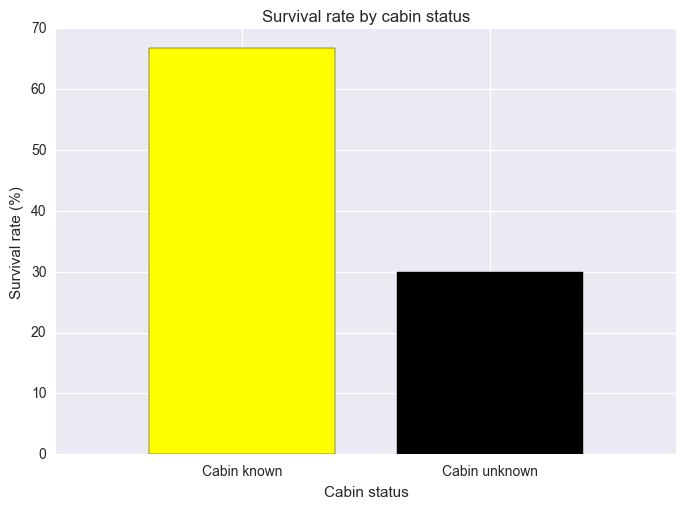

In [17]:
pclass = [0.75, 1.75]
ticks=["Cabin known","Cabin unknown"]
colors = ['Yellow', 'Black']
survival_rate = [train.loc[train['cabinUnknown'] == False, 'Survived'].mean() * 100, train.loc[train['cabinUnknown'] == True, 'Survived'].mean() * 100]
plt.bar(left=pclass, height=survival_rate, color=colors, width=0.75, tick_label=ticks, align='center')
plt.title("Survival rate by cabin status")
plt.xlabel("Cabin status")
plt.ylabel("Survival rate (%)")
plt.show()

* Be a grown man = much lower chance of survival
* Be a boy = average chance of survival
* Be a girl/woman = high chance of survival

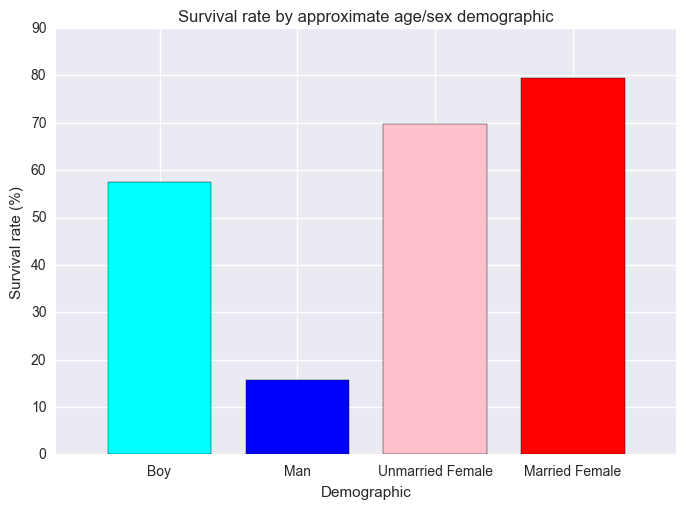

In [18]:
markers = [0.75, 1.75, 2.75, 3.75]
ticks=["Boy", "Man", "Unmarried Female", "Married Female"]
colors = ['cyan', 'blue', 'pink', 'red']
survival_rate = [train.loc[train['isMaster'] == True, 'Survived'].mean() * 100, train.loc[train['isMr'] == True, 'Survived'].mean() * 100, train.loc[train['isMiss'] == True, 'Survived'].mean() * 100, train.loc[train['isMrs'] == True, 'Survived'].mean() * 100]
plt.bar(left=markers, height=survival_rate, color=colors, width=0.75, tick_label=ticks, align='center')
plt.title("Survival rate by approximate age/sex demographic")
plt.xlabel("Demographic")
plt.ylabel("Survival rate (%)")
plt.ylim(0, 90)
plt.show()

* Embarked at port C = higher chance of survival
* Embarked at port S = lower chance of survival
* Embarked at port Q = average chance of survival

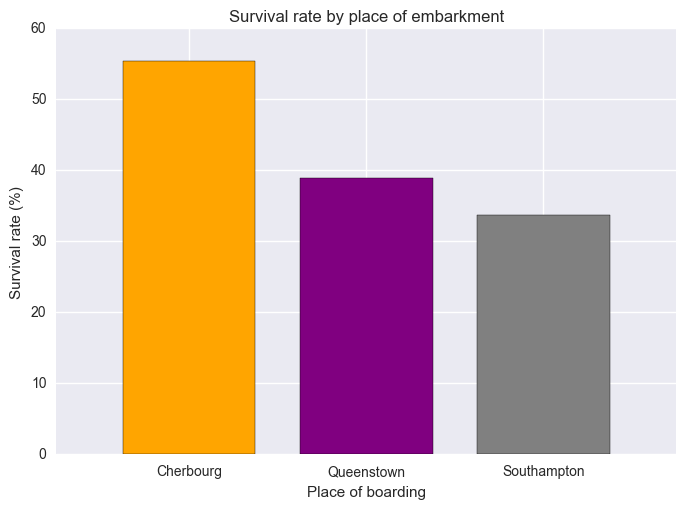

In [19]:
embarked = [0.75, 1.75, 2.75]
ticks=["Cherbourg", "Queenstown", "Southampton"]
colors = ['Orange', 'Purple', 'Gray']
survival_rate = [train.loc[train['Embarked_C'] == True, 'Survived'].mean() * 100, train.loc[train['Embarked_Q'] == True, 'Survived'].mean() * 100, train.loc[train['Embarked_S'] == True, 'Survived'].mean() * 100]
plt.bar(left=embarked, height=survival_rate, color=colors, width=0.75, tick_label=ticks, align='center')
plt.title("Survival rate by place of embarkment")
plt.xlabel("Place of boarding")
plt.ylabel("Survival rate (%)")
plt.show()

Let's break things down by a combination of variables. Class with demographic, class with boarding place, and demographic with boarding place. Maybe I can scrounge up an interaction term or two from this.

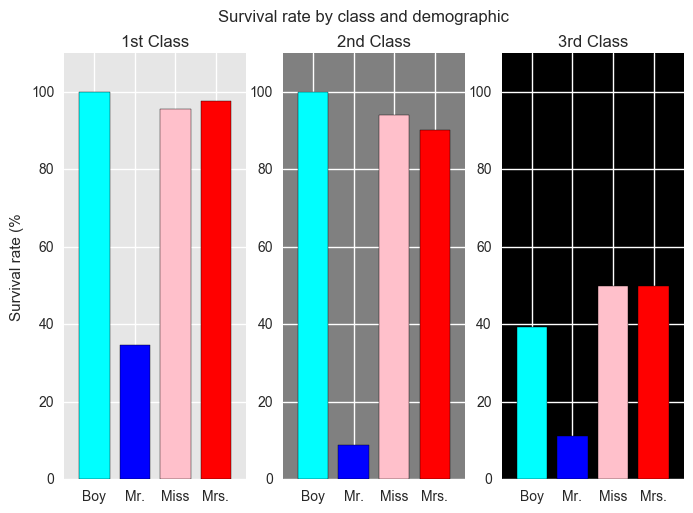

In [21]:
markers = [0.75, 1.75, 2.75, 3.75]
ticks=["Boy", "Mr.", "Miss", "Mrs."]
plt.suptitle("Survival rate by class and demographic")
colors = ['cyan', 'blue', 'pink', 'red']
survival_rate_1 = [train.loc[(train['isMaster'] == True) & (train['Pclass'] == 1), 'Survived'].mean() * 100, train.loc[(train['isMr'] == True) & (train['Pclass'] == 1), 'Survived'].mean() * 100, train.loc[(train['isMiss'] == True) & (train['Pclass'] == 1), 'Survived'].mean() * 100, train.loc[(train['isMrs'] == True) & (train['Pclass'] == 1), 'Survived'].mean() * 100]
survival_rate_2 = [train.loc[(train['isMaster'] == True) & (train['Pclass'] == 2), 'Survived'].mean() * 100, train.loc[(train['isMr'] == True) & (train['Pclass'] == 2), 'Survived'].mean() * 100, train.loc[(train['isMiss'] == True) & (train['Pclass'] == 2), 'Survived'].mean() * 100, train.loc[(train['isMrs'] == True) & (train['Pclass'] == 2), 'Survived'].mean() * 100]
survival_rate_3 = [train.loc[(train['isMaster'] == True) & (train['Pclass'] == 3), 'Survived'].mean() * 100, train.loc[(train['isMr'] == True) & (train['Pclass'] == 3), 'Survived'].mean() * 100, train.loc[(train['isMiss'] == True) & (train['Pclass'] == 3), 'Survived'].mean() * 100, train.loc[(train['isMrs'] == True) & (train['Pclass'] == 3), 'Survived'].mean() * 100]
plt.subplot(1, 3, 1, axisbg='#e6e6e6')
plt.bar(left=markers, height=survival_rate_1, color=colors, width=0.75, tick_label=ticks, align='center')
plt.ylim(0, 110)
plt.title('1st Class')
plt.ylabel("Survival rate (%")
plt.subplot(1, 3, 2, axisbg='#808080')
plt.bar(left=markers, height=survival_rate_2, color=colors, width=0.75, tick_label=ticks, align='center')
plt.ylim(0, 110)
plt.title('2nd Class')
plt.subplot(1, 3, 3, axisbg='black')
plt.bar(left=markers, height=survival_rate_3, color=colors, width=0.75, tick_label=ticks, align='center')
plt.ylim(0, 110)
plt.title('3rd Class')
plt.show()

Hmm. The results of plotting survival by class and title encourage me to tweak my features. Boys have a *100%* survival rate in the 1st and 2nd class, and there is almost no difference between the survival rates of married and unmarried females. I'll create the following features: "isChild" (0-12), "isAdult" (18+), and "upperClassChild" (1st or 2nd class and under 13). My new data munging process is below.

In [23]:
import pandas as pd

inputTrain = '../RawData/train.csv'
inputTest = '../RawData/test.csv'
outputTrain = '../ProcessedData/train.csv'
outputTest = '../ProcessedData/test.csv'

train = pd.read_csv(inputTrain, header=0)
test = pd.read_csv(inputTest, header=0)

avgAgeMaster = train.loc[train['Name'].str.contains(', Master. '), 'Age'].mean()
avgAgeMr = train.loc[train['Name'].str.contains(', Mr. '), 'Age'].mean()
avgAgeMrs = train.loc[train['Name'].str.contains(', Mrs. '), 'Age'].mean()
avgAgeMiss = train.loc[train['Name'].str.contains(', Miss. '), 'Age'].mean()
meanFare = train['Fare'].mean()


def processData(frame, outputURL):
    frame['ageUnknown'] = frame['Age'].isnull()
    frame['cabinUnknown'] = frame['Cabin'].isnull()
    
    frame['isMaster'] = frame['Name'].str.contains(', Master. ')
    frame.loc[(frame['isMaster'] == True) & (frame['Age'].isnull()), 'Age'] = avgAgeMaster
    
    frame['isMr'] = frame['Name'].str.contains(', Mr. ')
    frame.loc[(frame['isMr'] == True) & (frame['Age'].isnull()), 'Age'] = avgAgeMr
    frame.loc[(frame['Name'].str.contains(', Dr. ')) & (frame['Sex'] == 'male'), 'Age'] = avgAgeMr
    
    frame['isMrs'] = (frame['Name'].str.contains(', Mrs. ') | (frame['Name'].str.contains(', Dr. ')) & (frame['Sex'] == 'female'))
    frame.loc[((frame['isMrs'] == True) | (frame['Name'].str.contains(', Ms. '))) & (frame['Age'].isnull()), 'Age'] = avgAgeMrs
    #frame.loc[(frame['Name'].str.contains(', Dr. ')) & (frame['Sex'] == 'female'), 'Age'] = avgAgeMrs
    
    frame['isMiss'] = frame['Name'].str.contains(', Miss.')
    frame.loc[(frame['isMiss'] == True) & (frame['Age'].isnull()), 'Age'] = avgAgeMiss
    
    frame['hasNickname'] = frame['Name'].str.contains('\"')
    
    frame['hasTitle'] = ((frame['Name'].str.contains(', Dr. ') & (frame['Name'].str.contains(', Ms. ') == False)) | ((frame['isMr'] == False) & (frame['isMrs'] == False) & (frame['isMaster'] == False) & (frame['isMiss'] == False)))

    frame['A_Deck'] = False
    frame['B_Deck'] = False
    frame['C_Deck'] = False
    frame['D_Deck'] = False
    frame['E_Deck'] = False
    frame['F_Deck'] = False
    frame['G_Deck'] = False

    frame.loc[frame['cabinUnknown'] == False, 'A_Deck'] = frame['Cabin'].str.contains('A')
    frame.loc[frame['cabinUnknown'] == False, 'B_Deck'] = frame['Cabin'].str.contains('B')
    frame.loc[frame['cabinUnknown'] == False, 'C_Deck'] = frame['Cabin'].str.contains('C')
    frame.loc[frame['cabinUnknown'] == False, 'D_Deck'] = frame['Cabin'].str.contains('D')
    frame.loc[frame['cabinUnknown'] == False, 'E_Deck'] = frame['Cabin'].str.contains('E')
    frame.loc[frame['cabinUnknown'] == False, 'F_Deck'] = frame['Cabin'].str.contains('F')
    frame.loc[frame['cabinUnknown'] == False, 'G_Deck'] = frame['Cabin'].str.contains('G')
    
    frame = pd.get_dummies(frame, columns=['Embarked'])
    frame['isMale'] = (frame['Sex'] == 'male')
    frame['isChild'] = frame['Age'] <= 12
    frame['isAdult'] = frame['Age'] >= 18
    frame['upperClassChild'] = (frame['isChild'] == True) & (frame['Pclass'] < 3)
    
    del frame['Sex']
    
    frame.loc[frame['Fare'].isnull(), 'Fare'] = float(meanFare)
    
    del frame['Name']
    del frame['Cabin']
    del frame['Ticket']
    del frame['isMaster']
    del frame['isMr']
    del frame['isMiss']
    del frame['isMrs']
            
    frame.to_csv(outputURL, index=False)
    print("Done!")
    print(frame.info())

processData(train, outputTrain)
processData(test, outputTest)

Done!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 25 columns):
PassengerId        891 non-null int64
Survived           891 non-null int64
Pclass             891 non-null int64
Age                891 non-null float64
SibSp              891 non-null int64
Parch              891 non-null int64
Fare               891 non-null float64
ageUnknown         891 non-null bool
cabinUnknown       891 non-null bool
hasNickname        891 non-null bool
hasTitle           891 non-null bool
A_Deck             891 non-null bool
B_Deck             891 non-null bool
C_Deck             891 non-null bool
D_Deck             891 non-null bool
E_Deck             891 non-null bool
F_Deck             891 non-null bool
G_Deck             891 non-null bool
Embarked_C         891 non-null float64
Embarked_Q         891 non-null float64
Embarked_S         891 non-null float64
isMale             891 non-null bool
isChild            891 non-null bool
isAdult           

In [25]:
trainPath = '../ProcessedData/train.csv'

train = pd.read_csv(trainPath, header=0, index_col=0)
train.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,ageUnknown,cabinUnknown,hasNickname,hasTitle,...,E_Deck,F_Deck,G_Deck,Embarked_C,Embarked_Q,Embarked_S,isMale,isChild,isAdult,upperClassChild
Survived,1.000000,-0.338481,-0.089135,-0.035322,0.081629,0.257307,-0.092197,-0.316912,0.172276,2.203026e-02,...,0.150716,0.057935,-0.017955,0.168240,0.003650,-0.155660,-0.543351,0.117636,-0.123616,0.181632
Pclass,-0.338481,1.000000,-0.339559,0.083081,0.018443,-0.549500,0.172933,0.725541,0.032038,-2.063325e-01,...,-0.221793,0.011063,0.073625,-0.243292,0.221009,0.081720,0.131900,0.124732,-0.134770,-0.092801
Age,-0.089135,-0.339559,1.000000,-0.271294,-0.195619,0.087487,0.008541,-0.236610,-0.105070,1.443916e-01,...,0.109270,-0.079650,-0.060506,0.041582,-0.050171,-0.012549,0.114682,-0.563867,0.612361,-0.305967
SibSp,-0.035322,0.083081,-0.271294,1.000000,0.414838,0.159651,0.018958,0.040460,-0.020319,-3.636370e-02,...,-0.033751,0.001706,-0.019159,-0.059528,-0.026354,0.070941,-0.114631,0.385491,-0.352191,0.040389
Parch,0.081629,0.018443,-0.195619,0.414838,1.000000,0.216225,-0.124104,-0.036987,0.010458,-6.748012e-02,...,-0.011748,0.023694,0.036749,-0.011069,-0.081228,0.063036,-0.245489,0.376629,-0.327326,0.211097
Fare,0.257307,-0.549500,0.087487,0.159651,0.216225,1.000000,-0.100707,-0.482075,-0.042638,2.458515e-02,...,0.051749,-0.033093,-0.037921,0.269335,-0.117216,-0.166603,-0.182333,-0.004070,0.007657,0.047259
ageUnknown,-0.092197,0.172933,0.008541,0.018958,-0.124104,-0.100707,1.000000,0.144111,0.088855,-7.160639e-02,...,-0.052960,-0.013665,-0.044306,0.033270,0.337413,-0.238377,0.055215,-0.107712,0.160265,-0.077355
cabinUnknown,-0.316912,0.725541,-0.236610,0.040460,-0.036987,-0.482075,0.144111,1.000000,0.046695,-1.062464e-01,...,-0.359896,-0.223299,-0.163300,-0.208528,0.129572,0.110087,0.140391,0.055651,-0.061594,-0.056204
hasNickname,0.172276,0.032038,-0.105070,-0.020319,0.010458,-0.042638,0.088855,0.046695,1.000000,3.858539e-02,...,0.000931,0.048545,-0.022379,-0.012049,0.159074,-0.088064,-0.132324,0.063283,-0.070814,0.023485
hasTitle,0.022030,-0.206333,0.144392,-0.036364,-0.067480,0.024585,-0.071606,-0.106246,0.038585,1.000000e+00,...,-0.034669,-0.021510,-0.015731,0.065432,-0.007767,-0.051415,0.034471,-0.052809,0.068730,-0.027465


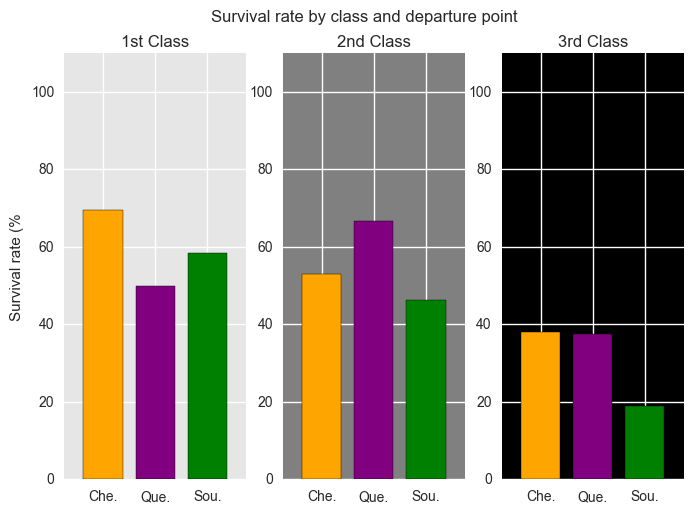

In [22]:
markers = [0.75, 1.75, 2.75]
ticks=["Che.", "Que.", "Sou."]
plt.suptitle("Survival rate by class and departure point")
colors = ['orange', 'purple', 'green']
survival_rate_1 = [train.loc[(train['Embarked_C'] == True) & (train['Pclass'] == 1), 'Survived'].mean() * 100, train.loc[(train['Embarked_Q'] == True) & (train['Pclass'] == 1), 'Survived'].mean() * 100, train.loc[(train['Embarked_S'] == True) & (train['Pclass'] == 1), 'Survived'].mean() * 100]
survival_rate_2 = [train.loc[(train['Embarked_C'] == True) & (train['Pclass'] == 2), 'Survived'].mean() * 100, train.loc[(train['Embarked_Q'] == True) & (train['Pclass'] == 2), 'Survived'].mean() * 100, train.loc[(train['Embarked_S'] == True) & (train['Pclass'] == 2), 'Survived'].mean() * 100]
survival_rate_3 = [train.loc[(train['Embarked_C'] == True) & (train['Pclass'] == 3), 'Survived'].mean() * 100, train.loc[(train['Embarked_Q'] == True) & (train['Pclass'] == 3), 'Survived'].mean() * 100, train.loc[(train['Embarked_S'] == True) & (train['Pclass'] == 3), 'Survived'].mean() * 100]
plt.subplot(1, 3, 1, axisbg='#e6e6e6')
plt.bar(left=markers, height=survival_rate_1, color=colors, width=0.75, tick_label=ticks, align='center')
plt.ylim(0, 110)
plt.title('1st Class')
plt.ylabel("Survival rate (%")
plt.subplot(1, 3, 2, axisbg='#808080')
plt.bar(left=markers, height=survival_rate_2, color=colors, width=0.75, tick_label=ticks, align='center')
plt.ylim(0, 110)
plt.title('2nd Class')
plt.subplot(1, 3, 3, axisbg='black')
plt.bar(left=markers, height=survival_rate_3, color=colors, width=0.75, tick_label=ticks, align='center')
plt.ylim(0, 110)
plt.title('3rd Class')
plt.show()

The distributions differ enough by class that an interaction term might be justified in a linear model. The effects are not very dramatic, though, and the difference can be handled by decision trees, so I won't bother making an interaction term. This problem seems to lend itself well to trees.

# P-value and t-value testing

In [ ]:
Do this.

# Machine learning with the "Random Forest" algorithm
This machine learning problem lends itself well to a decision tree solution because there seem to be a number of conditional probabilities involved in prediction.

Random Forest aggregates the results of many simulated decision trees, using a different number of trees and features per instance of the algorithm. I will tune the random forest, on the training set, with a reasonable range for both parameters (10-35 trees per forest, and 5-22 features per forest). The models will be evaluated by their respective F-scores, a harmonic average between precision and recall.

I will then test the best model on the test set.

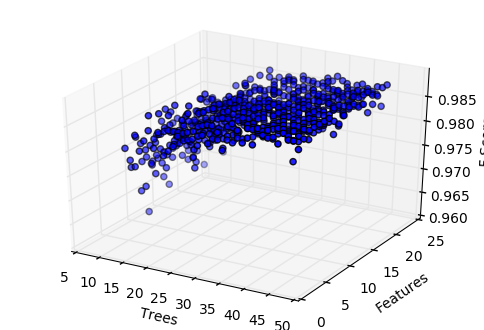

Top score on training set: 0.987654320988
Number of estimators in best model: 24.0
Max features of best model: 12.0
0.818181818182
[[228  38]
 [ 38 114]]
             precision    recall  f1-score   support

          0       0.86      0.86      0.86       266
          1       0.75      0.75      0.75       152

avg / total       0.82      0.82      0.82       418



In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import confusion_matrix, classification_report

random.seed(1)

testPath = '../ProcessedData/test.csv'
trainPath = '../ProcessedData/train.csv'
survivedPath = '../RawData/survived_test.csv'

train = pd.read_csv(trainPath, header=0, index_col=0)
X_test = pd.read_csv(testPath, header=0, index_col=0)
y_test = pd.read_csv(survivedPath, header=0, index_col=0)

y_train = train['Survived']
X_train = train.drop(['Survived'], axis=1)

estimators = np.linspace(10, 45, 36)
max_features = np.linspace(5, 23, 19)
forest_scores = [[]]

for i in range(len(estimators)):
    for j in range(len(max_features)):
        clf = RandomForestClassifier(n_estimators=int(estimators[i]), max_features=int(max_features[j]))
        clf.fit(X_train, y_train)
        while len(forest_scores) < (i+1):
            forest_scores.append([])
        forest_scores[i].append(clf.score(X_train, y_train))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# reshape data to same dimensions for 3D plotting purposes
estimators_3D = []
max_features_3D = []
scores_3D = []
for i in range(0, len(estimators)):
    for j in range(0, len(max_features)):
        estimators_3D.append(estimators[i])
        max_features_3D.append(max_features[j])
        scores_3D.append(forest_scores[i][j])
ax.scatter(estimators_3D, max_features_3D, scores_3D)
ax.set_xlabel("Trees")
ax.set_ylabel("Features")
ax.set_zlabel("F-Score")
plt.show()

max_score = max(scores_3D)
scores_3D = np.array(scores_3D)
max_index = np.argmax(scores_3D)
estimators_best = estimators_3D[max_index]
max_features_best = max_features_3D[max_index]
print("Top score on training set: " + str(max_score))
print("Number of estimators in best model: " + str(estimators_best))
print("Max features of best model: " + str(max_features_best))

clf = RandomForestClassifier(n_estimators=int(estimators_best), max_features=int(max_features_best))
clf.fit(X_train, y_train)
print(str(clf.score(X_test, y_test)))

y_pred = pd.DataFrame(clf.predict(X_test)) 
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

idRange = range(892, 1310)
y_pred['PassengerId'] = idRange
y_pred.columns = ["Survived", "PassengerId"]
y_pred = y_pred[['PassengerId', 'Survived']]
y_pred.to_csv('../Predictions/predictions_forest.csv', index=False)

The optimal model scores an acceptable 81.8% on the F-score. But the number of features in the optimal model is low enough (12) that I should consider feature selection before trying any other model types. Lasso regression strikes me as a good way to weed out the less-useful variables without too much thought. 

# Ridge Regression

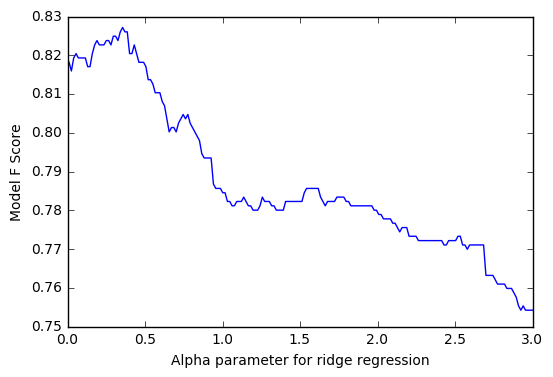

0.748803827751
[[250  16]
 [ 89  63]]
             precision    recall  f1-score   support

          0       0.74      0.94      0.83       266
          1       0.80      0.41      0.55       152

avg / total       0.76      0.75      0.72       418



In [4]:
import pandas as pd
from sklearn.linear_model import Ridge
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, classification_report

alpha_ridge = np.linspace(0.01, 3, 200)

testPath = '../ProcessedData/test.csv'
trainPath = '../ProcessedData/train.csv'
survivedPath = '../RawData/survived_test.csv'

train = pd.read_csv(trainPath, header=0, index_col=0)
X_test = pd.read_csv(testPath, header=0, index_col=0)
y_test = pd.read_csv(survivedPath, header=0, index_col=0)

y_train = train['Survived']
X_train = train.drop(['Survived'], axis=1)
ridge_scores = []

for i in range(len(alpha_ridge)):
    alpha = alpha_ridge[i]
    clf = OneVsRestClassifier(Ridge(alpha=alpha,normalize=True))
    clf.fit(X_train, y_train)
    #y_pred = ridgereg.predict(X_test)
    ridge_scores.append(clf.score(X_train, y_train))

plt.plot(alpha_ridge, ridge_scores)
plt.xlabel("Alpha parameter for ridge regression")
plt.ylabel("Model F Score")
plt.show()

maxAlpha = alpha_ridge[np.argmax(ridge_scores)]
clf = OneVsRestClassifier(Ridge(alpha=alpha,normalize=True))
clf.fit(X_train, y_train)
print(str(clf.score(X_test, y_test)))

y_pred = pd.DataFrame(clf.predict(X_test)) 
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

idRange = range(892, 1310)
y_pred['PassengerId'] = idRange
y_pred.columns = ["Survived", "PassengerId"]
y_pred = y_pred[['PassengerId', 'Survived']]
y_pred.to_csv('../Predictions/predictions_ridge.csv', index=False)

Yuck. Achieving a significantly lower F score than I did with random forest, ridge regression appears unpromising. This despite tuning for an optimal Alpha parameter (which penalizes the weights of each feature). 

Let's get a little bit simpler. Let's do a logistic regression, an algorithm tailor-made for 0 vs 1 classification.

# Logistic regression

In [5]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, classification_report

testPath = '../ProcessedData/test.csv'
trainPath = '../ProcessedData/train.csv'
survivedPath = '../RawData/survived_test.csv'

train = pd.read_csv(trainPath, header=0)
X_test = pd.read_csv(testPath, header=0)
y_test = pd.read_csv(survivedPath, header=0, index_col=0)

y_train = train['Survived']
X_train = train.drop(['Survived'], axis=1)

clf = OneVsRestClassifier(LogisticRegression())

clf.fit(X_train, y_train)

print(str(clf.score(X_test, y_test)))

y_pred = pd.DataFrame(clf.predict(X_test)) 

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

y_pred_prob = pd.DataFrame(clf.predict_proba(X_test)[:,1])

idRange = range(892, 1310)
y_pred['PassengerId'] = idRange
y_pred.columns = ["Survived", "PassengerId"]
y_pred = y_pred[['PassengerId', 'Survived']]
y_pred.to_csv('../Predictions/predictions_logistic.csv', index=False)

0.928229665072
[[247  19]
 [ 11 141]]
             precision    recall  f1-score   support

          0       0.96      0.93      0.94       266
          1       0.88      0.93      0.90       152

avg / total       0.93      0.93      0.93       418



# Conclusion

My logistic regression model yielding a very healthy 92.8% F-score, I do not imagine that I can improve upon this model without overfitting. It's time to move on to a more practical project.

Kaggle claims my accuracy with this model is a mere 76.077%, but it only tested my predictions on half of the data set. I suspect they test the model on some of the trickiest data points.

76.077%, despite what the Kaggle leaderboard would suggest, is a respectable number. Unlike many of the submitters ahead of me, I do not cheat with my models. Following best data science practice, all of my models trained on the training data and tested on the test data. 

Should I choose to revisit this project, I will do the following things:
* Use bootstrapping to simulate larger data sets, and cross-validate my models on the larger sets.
* Make all variables binary, and attempt a Naive Bayes classification.